In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import ast

In [2]:
pd.__version__

'1.3.4'

#### load data

In [33]:
path_data = Path(Path.home()/'pKalculator'/'data')

#Load data from paper
df_paper_neutral = pd.read_excel(path_data/"data_paper_neutral.ods", engine="odf")
df_paper_anions = pd.read_excel(path_data/"data_paper_anions.ods", engine="odf")
df_pKa_paper = pd.read_csv(path_data/'pKa_paper.csv')
df_compounds = pd.read_csv(path_data/'compounds_paper.smiles', delimiter=' ')

#load calculated data
df_pKa_DMSO = pd.read_csv(path_data/'pKa_DMSO.csv')

In [34]:
df_pKa_paper

,name_paper,pKa_paper
0,a1-2,35.0
1,a1-3,38.5
2,a2-2,33.5
3,a2-3,39.1
4,a3-2,39.6
...,...,...
186,d7-8,40.0
187,d8-2,36.1
188,d8-4,33.5
189,d8-6,34.6


In [35]:
df_pKa_DMSO.head()

,name,smiles,pka_exp,pka_theor,ref,E_neutral,lst_smiles_deprot,lst_name_deprot,lst_E,lst_E_rel,lst_pKa,lst_atomsite,gfn_method,solvent_model,solvent_name,file
0,furan,O1C=CC=C1,35.0,35.0,5a,-9595.823808,"['[C-]1=CC=CO1', '[C-]1=COC=C1']","['furan#-1=2', 'furan#-1=3']","[-9395.793654314173, -9393.17621670316]","[200.030153253987, 202.6475908650009]","[35.0, 36.9]","[2, 3]",gfn 1,alpb,DMSO,36405291_0_result.pkl
1,thiophene,S1C=CC=C1,32.5,33.5,5a,-8964.806360,"['[C-]1=CC=CS1', '[C-]1=CSC=C1']","['thiophene#-1=2', 'thiophene#-1=3']","[-8765.104594066052, -8760.672880015574]","[199.7017661268801, 204.13348017735734]","[34.8, 38.0]","[2, 3]",gfn 1,alpb,DMSO,36405291_0_result.pkl
2,"N,N-dimethyl-1H-pyrrol-1-amine",CN(N1C=CC=C1)C,36.4,38.7,5a,-15324.221108,"['CN(C)N1[C-]=CC=C1', 'CN(C)N1C=[C-]C=C1', '[C...","['N,N-dimethyl-1H-pyrrol-1-amine#-1=4', 'N,N-d...","[-15122.60689986009, -15111.15791714897, -1512...","[201.61420790572083, 213.06319061684007, 204.2...","[36.2, 44.6, 38.1]","[4, 5, 1]",gfn 1,alpb,DMSO,36405291_0_result.pkl
3,1-methyl-1H-imidazole,CN1C=CN=C1,33.1,35.1,5a,-11334.425519,"['CN1[C-]=CN=C1', 'CN1[C-]=NC=C1', 'CN1C=[C-]N...","['1-methyl-1H-imidazole#-1=3', '1-methyl-1H-im...","[-11133.427329189315, -11130.725809739643, -11...","[200.99818940037585, 203.6997088500484, 215.24...","[35.7, 37.7, 46.2, 28.1]","[3, 6, 4, 1]",gfn 1,alpb,DMSO,36405291_0_result.pkl
4,thiazole,S1C=CN=C1,29.4,29.6,5b,-9303.623441,"['[C-]1=CN=CS1', '[C-]1=CSC=N1', '[C-]1=NC=CS1']","['thiazole#-1=2', 'thiazole#-1=3', 'thiazole#-...","[-9110.000607994762, -9100.344798304646, -9106...","[193.62283332065454, 203.27864301076988, 197.3...","[30.3, 37.4, 33.0]","[2, 3, 5]",gfn 1,alpb,DMSO,36405291_0_result.pkl


In [36]:
lst_name_numAnion = [('furan', 2),
('thiophene', 2),
('N,N-dimethyl-1H-pyrrol-1-amine', 4),
('1-methyl-1H-imidazole', 6),
('thiazole', 5),
('1-propyl-1H-pyrazole', 8),
('1-methyl-1H-indole', 3),
('benzo[b]thiophene', 3),
('benzofuran', 3),
('benzo[d]oxazole', 3)
]

df_anion_site = pd.DataFrame(lst_name_numAnion, columns=['name', 'anion_site'])


In [37]:
df_anion_site

,name,anion_site
0,furan,2
1,thiophene,2
2,"N,N-dimethyl-1H-pyrrol-1-amine",4
3,1-methyl-1H-imidazole,6
4,thiazole,5
5,1-propyl-1H-pyrazole,8
6,1-methyl-1H-indole,3
7,benzo[b]thiophene,3
8,benzofuran,3
9,benzo[d]oxazole,3


In [38]:
# df_anion_site['idx_anion_site'] = pd.Series(dtype='int')
for idx, row in df_anion_site.iterrows():
    name = row['name']
    anion_site = row['anion_site']
    
    idx_ref = df_pKa_DMSO.index[df_pKa_DMSO['name'] == name][0] #only take the first index as the order of theanion sites will be the same
# # idx_deprot = ast.literal_eval(df.at[idx_ref, 'lst_name_deprot']).index('furan#-1=2')
    idx_anion_site = ast.literal_eval(df_pKa_DMSO.at[idx_ref, 'lst_atomsite']).index(anion_site)
    df_anion_site.at[idx, 'idx_anion_site'] = int(idx_anion_site)

df_anion_site['idx_anion_site'] = df_anion_site['idx_anion_site'].astype(int)

In [39]:
df_anion_site

,name,anion_site,idx_anion_site
0,furan,2,0
1,thiophene,2,0
2,"N,N-dimethyl-1H-pyrrol-1-amine",4,0
3,1-methyl-1H-imidazole,6,1
4,thiazole,5,2
5,1-propyl-1H-pyrazole,8,0
6,1-methyl-1H-indole,3,0
7,benzo[b]thiophene,3,0
8,benzofuran,3,0
9,benzo[d]oxazole,3,4


In [40]:
for idx, row in df_pKa_DMSO.iterrows():
    name = row['name']
    df_anion_site['name']
    idx_anion_site = int(df_anion_site.idx_anion_site[df_anion_site['name'] == name])
    pKa_anion_site = ast.literal_eval(df_pKa_DMSO.at[idx, 'lst_pKa'])[idx_anion_site]
    df_pKa_DMSO.at[idx, 'pKa_calc'] = pKa_anion_site

In [41]:
# df_pKa_DMSO['gfn_method'] = df_pKa_DMSO['gfn_method'].str.replace('gfn   ', '')
df_pKa_DMSO['gfn_method'] = df_pKa_DMSO['gfn_method'].str.replace(' ', '') #.str.replace('gfn   ', '')

In [42]:
df_pKa_DMSO = df_pKa_DMSO[[
    'name',
    'smiles',
    'pka_exp',
    'pka_theor',
    'ref',
    'pKa_calc',
    'E_neutral',
    'lst_smiles_deprot',
    'lst_name_deprot',
    'lst_E',
    'lst_E_rel',
    'lst_pKa',
    'lst_atomsite',
    'gfn_method',
    'solvent_model',
    'solvent_name',
    'file']]

In [43]:
df_pKa_DMSO.head()

,name,smiles,pka_exp,pka_theor,ref,pKa_calc,E_neutral,lst_smiles_deprot,lst_name_deprot,lst_E,lst_E_rel,lst_pKa,lst_atomsite,gfn_method,solvent_model,solvent_name,file
0,furan,O1C=CC=C1,35.0,35.0,5a,35.0,-9595.823808,"['[C-]1=CC=CO1', '[C-]1=COC=C1']","['furan#-1=2', 'furan#-1=3']","[-9395.793654314173, -9393.17621670316]","[200.030153253987, 202.6475908650009]","[35.0, 36.9]","[2, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl
1,thiophene,S1C=CC=C1,32.5,33.5,5a,34.8,-8964.806360,"['[C-]1=CC=CS1', '[C-]1=CSC=C1']","['thiophene#-1=2', 'thiophene#-1=3']","[-8765.104594066052, -8760.672880015574]","[199.7017661268801, 204.13348017735734]","[34.8, 38.0]","[2, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl
2,"N,N-dimethyl-1H-pyrrol-1-amine",CN(N1C=CC=C1)C,36.4,38.7,5a,36.2,-15324.221108,"['CN(C)N1[C-]=CC=C1', 'CN(C)N1C=[C-]C=C1', '[C...","['N,N-dimethyl-1H-pyrrol-1-amine#-1=4', 'N,N-d...","[-15122.60689986009, -15111.15791714897, -1512...","[201.61420790572083, 213.06319061684007, 204.2...","[36.2, 44.6, 38.1]","[4, 5, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
3,1-methyl-1H-imidazole,CN1C=CN=C1,33.1,35.1,5a,37.7,-11334.425519,"['CN1[C-]=CN=C1', 'CN1[C-]=NC=C1', 'CN1C=[C-]N...","['1-methyl-1H-imidazole#-1=3', '1-methyl-1H-im...","[-11133.427329189315, -11130.725809739643, -11...","[200.99818940037585, 203.6997088500484, 215.24...","[35.7, 37.7, 46.2, 28.1]","[3, 6, 4, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
4,thiazole,S1C=CN=C1,29.4,29.6,5b,33.0,-9303.623441,"['[C-]1=CN=CS1', '[C-]1=CSC=N1', '[C-]1=NC=CS1']","['thiazole#-1=2', 'thiazole#-1=3', 'thiazole#-...","[-9110.000607994762, -9100.344798304646, -9106...","[193.62283332065454, 203.27864301076988, 197.3...","[30.3, 37.4, 33.0]","[2, 3, 5]",gfn1,alpb,DMSO,36405291_0_result.pkl


In [44]:
df_pKa_DMSO.shape

(40, 17)

In [45]:
set(df_pKa_DMSO['gfn_method'])

{'gfn1', 'gfn2'}

In [46]:
df_pKa_DMSO.loc[df_pKa_DMSO['gfn_method']== 'gfn2']

,name,smiles,pka_exp,pka_theor,ref,pKa_calc,E_neutral,lst_smiles_deprot,lst_name_deprot,lst_E,lst_E_rel,lst_pKa,lst_atomsite,gfn_method,solvent_model,solvent_name,file
10,furan,O1C=CC=C1,35.0,35.0,5a,35.0,-9193.625030,"['[C-]1=CC=CO1', '[C-]1=COC=C1']","['furan#-1=2', 'furan#-1=3']","[-8995.82790190762, -8986.317282436006]","[197.79712793161707, 207.30774740323068]","[35.0, 42.0]","[2, 3]",gfn2,alpb,DMSO,36405294_0_result.pkl
11,thiophene,S1C=CC=C1,32.5,33.5,5a,30.1,-8675.292034,"['[C-]1=CC=CS1', '[C-]1=CSC=C1']","['thiophene#-1=2', 'thiophene#-1=3']","[-8484.1649456893, -8479.065246324202]","[191.1270882297158, 196.22678759481278]","[30.1, 33.8]","[2, 3]",gfn2,alpb,DMSO,36405294_0_result.pkl
12,"N,N-dimethyl-1H-pyrrol-1-amine",CN(N1C=CC=C1)C,36.4,38.7,5a,43.7,-14917.306115,"['CN(C)N1[C-]=CC=C1', 'CN(C)N1C=[C-]C=C1', '[C...","['N,N-dimethyl-1H-pyrrol-1-amine#-1=4', 'N,N-d...","[-14707.65734099641, -14695.479405204398, -147...","[209.64877431676723, 221.82671010877857, 210.3...","[43.7, 52.6, 44.2]","[4, 5, 1]",gfn2,alpb,DMSO,36405294_0_result.pkl
13,1-methyl-1H-imidazole,CN1C=CN=C1,33.1,35.1,5a,38.3,-10969.034355,"['CN1[C-]=CN=C1', 'CN1[C-]=NC=C1', 'CN1C=[C-]N...","['1-methyl-1H-imidazole#-1=3', '1-methyl-1H-im...","[-10767.949820130612, -10766.73988113525, -107...","[201.08453521665797, 202.29447421201985, 215.3...","[37.4, 38.3, 47.8, 27.4]","[3, 6, 4, 1]",gfn2,alpb,DMSO,36405294_0_result.pkl
14,thiazole,S1C=CN=C1,29.4,29.6,5b,21.7,-8851.789784,"['[C-]1=CN=CS1', '[C-]1=CSC=N1', '[C-]1=NC=CS1']","['thiazole#-1=2', 'thiazole#-1=3', 'thiazole#-...","[-8670.443516135732, -8663.120737908916, -8672...","[181.34626774063872, 188.66904596745553, 179.6...","[22.9, 28.3, 21.7]","[2, 3, 5]",gfn2,alpb,DMSO,36405294_0_result.pkl
15,1-propyl-1H-pyrazole,CCCN1N=CC=C1,35.2,35.2,5a,35.9,-14932.612376,"['CCCN1[C-]=CC=N1', 'CCCN1C=[C-]C=N1', 'CCCN1C...","['1-propyl-1H-pyrazole#-1=8', '1-propyl-1H-pyr...","[-14733.596932763967, -14720.023371305555, -14...","[199.01544281048518, 212.58900426889704, 215.4...","[35.9, 45.8, 47.9, 29.7, 43.6, 46.2]","[8, 7, 6, 3, 2, 1]",gfn2,alpb,DMSO,36405294_0_result.pkl
16,1-methyl-1H-indole,CN(C=C1)C2=C1C=CC=C2,37.3,37.7,5a,39.2,-16817.576187,"['CN1[C-]=CC2=C1C=CC=C2', 'CN1C=[C-]C2=C1C=CC=...","['1-methyl-1H-indole#-1=3', '1-methyl-1H-indol...","[-16614.099834129796, -16601.66621260341, -165...","[203.47635315301522, 215.90997467940178, 217.7...","[39.2, 48.3, 49.6, 51.1, 49.7, 45.6, 32.7]","[3, 4, 7, 8, 9, 10, 1]",gfn2,alpb,DMSO,36405294_0_result.pkl
17,benzo[b]thiophene,C1(SC=C2)=C2C=CC=C1,32.9,32.0,5a,27.3,-14703.186807,"['[C-]1=CC2=C(C=CC=C2)S1', '[C-]1=CC2=C(C=C1)C...","['benzo[b]thiophene#-1=3', 'benzo[b]thiophene#...","[-14515.855531958652, -14498.507444191297, -14...","[187.33127541513204, 204.67936318248758, 207.3...","[27.3, 40.0, 42.0, 39.3, 39.0, 54653.4]","[3, 8, 7, 9, 6, 4]",gfn2,alpb,DMSO,36405294_0_result.pkl
18,benzofuran,C1(OC=C2)=C2C=CC=C1,32.7,33.2,5b,30.7,-15220.334602,"['[C-]1=CC2=C(C=CC=C2)O1', '[C-]1=CC2=C(C=C1)C...","['benzofuran#-1=3', 'benzofuran#-1=8', 'benzof...","[-15028.412874619495, -15011.765314713328, -15...","[191.9217272503247, 208.56928715649155, 210.51...","[30.7, 42.9, 44.3, 40.4, 42.4, 37.9]","[3, 8, 7, 9, 6, 4]",gfn2,alpb,DMSO,36405294_0_result.pkl
19,benzo[d]oxazole,C1(OC=N2)=C2C=CC=C1,24.4,24.8,5b,22.8,-15397.630420,"['[C-]1=CC2=C(C=C1)N=CO2', '[C-]1=CC2=C(C=C1)O...","['benzo[d]oxazole#-1=8', 'benzo[d]oxazole#-1=7...","[-15195.78470572758, -15193.549114751779, -151...","[201.84571391542886, 204.0813048912296, 197.75...","[38.0, 39.6, 35.0, 37.9, 22.8]","[8, 7, 9, 6, 3]",gfn2,alpb,DMSO,36405294_0_result.pkl


### Create plots

In [47]:
[1, 'gbsa']
[2, 'gbsa']
[1, 'alpb']
[2, 'alpb']

[2, 'alpb']

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df_pKa_DMSO[df_pKa_DMSO['solvent_name'] == 'DMSO'].sort_values(by=['gfn_method', 'solvent_model'])

,name,smiles,pka_exp,pka_theor,ref,pKa_calc,E_neutral,lst_smiles_deprot,lst_name_deprot,lst_E,lst_E_rel,lst_pKa,lst_atomsite,gfn_method,solvent_model,solvent_name,file
0,furan,O1C=CC=C1,35.0,35.0,5a,35.0,-9595.823808,"['[C-]1=CC=CO1', '[C-]1=COC=C1']","['furan#-1=2', 'furan#-1=3']","[-9395.793654314173, -9393.17621670316]","[200.030153253987, 202.6475908650009]","[35.0, 36.9]","[2, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl
1,thiophene,S1C=CC=C1,32.5,33.5,5a,34.8,-8964.806360,"['[C-]1=CC=CS1', '[C-]1=CSC=C1']","['thiophene#-1=2', 'thiophene#-1=3']","[-8765.104594066052, -8760.672880015574]","[199.7017661268801, 204.13348017735734]","[34.8, 38.0]","[2, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl
2,"N,N-dimethyl-1H-pyrrol-1-amine",CN(N1C=CC=C1)C,36.4,38.7,5a,36.2,-15324.221108,"['CN(C)N1[C-]=CC=C1', 'CN(C)N1C=[C-]C=C1', '[C...","['N,N-dimethyl-1H-pyrrol-1-amine#-1=4', 'N,N-d...","[-15122.60689986009, -15111.15791714897, -1512...","[201.61420790572083, 213.06319061684007, 204.2...","[36.2, 44.6, 38.1]","[4, 5, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
3,1-methyl-1H-imidazole,CN1C=CN=C1,33.1,35.1,5a,37.7,-11334.425519,"['CN1[C-]=CN=C1', 'CN1[C-]=NC=C1', 'CN1C=[C-]N...","['1-methyl-1H-imidazole#-1=3', '1-methyl-1H-im...","[-11133.427329189315, -11130.725809739643, -11...","[200.99818940037585, 203.6997088500484, 215.24...","[35.7, 37.7, 46.2, 28.1]","[3, 6, 4, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
4,thiazole,S1C=CN=C1,29.4,29.6,5b,33.0,-9303.623441,"['[C-]1=CN=CS1', '[C-]1=CSC=N1', '[C-]1=NC=CS1']","['thiazole#-1=2', 'thiazole#-1=3', 'thiazole#-...","[-9110.000607994762, -9100.344798304646, -9106...","[193.62283332065454, 203.27864301076988, 197.3...","[30.3, 37.4, 33.0]","[2, 3, 5]",gfn1,alpb,DMSO,36405291_0_result.pkl
5,1-propyl-1H-pyrazole,CCCN1N=CC=C1,35.2,35.2,5a,32.1,-15343.247962,"['CCCN1[C-]=CC=N1', 'CCCN1C=[C-]C=N1', 'CCCN1C...","['1-propyl-1H-pyrazole#-1=8', '1-propyl-1H-pyr...","[-15147.169450558556, -15136.638020832806, -15...","[196.07851187709275, 206.6099416028428, 213.37...","[32.1, 39.8, 44.8, 24.3, 37.9, 40.3]","[8, 7, 6, 3, 2, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
6,1-methyl-1H-indole,CN(C=C1)C2=C1C=CC=C2,37.3,37.7,5a,33.1,-16987.215461,"['CN1[C-]=CC2=C1C=CC=C2', 'CN1C=[C-]C2=C1C=CC=...","['1-methyl-1H-indole#-1=3', '1-methyl-1H-indol...","[-16789.75498383347, -16781.476056453805, -167...","[197.46047731986982, 205.73940469953595, 207.7...","[33.1, 39.2, 40.7, 41.3, 40.5, 36.1, 28.8]","[3, 4, 7, 8, 9, 10, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
7,benzo[b]thiophene,C1(SC=C2)=C2C=CC=C1,32.9,32.0,5a,29.5,-14958.630831,"['[C-]1=CC2=C(C=CC=C2)S1', '[C-]1=CC2=C(C=C1)C...","['benzo[b]thiophene#-1=3', 'benzo[b]thiophene#...","[-14766.111353420123, -14756.256546549515, -14...","[192.51947722735167, 202.3742840979594, 203.51...","[29.5, 36.7, 37.6, 35.0, 36.7, 32.3]","[3, 8, 7, 9, 6, 4]",gfn1,alpb,DMSO,36405291_0_result.pkl
8,benzofuran,C1(OC=C2)=C2C=CC=C1,32.7,33.2,5b,28.4,-15588.401573,"['[C-]1=CC2=C(C=CC=C2)O1', '[C-]1=CC2=C(C=C1)C...","['benzofuran#-1=3', 'benzofuran#-1=8', 'benzof...","[-15397.413168816844, -15387.71360484016, -153...","[190.9884045220333, 200.68796849871615, 201.81...","[28.4, 35.5, 36.3, 32.0, 35.3, 30.8]","[3, 8, 7, 9, 6, 4]",gfn1,alpb,DMSO,36405291_0_result.pkl
9,benzo[d]oxazole,C1(OC=N2)=C2C=CC=C1,24.4,24.8,5b,23.5,-15927.533118,"['[C-]1=CC2=C(C=C1)N=CO2', '[C-]1=CC2=C(C=C1)O...","['benzo[d]oxazole#-1=8', 'benzo[d]oxazole#-1=7...","[-15729.973318218676, -15728.977442085485, -15...","[197.55980018268383, 198.55567631587473, 192.3...","[33.2, 33.9, 29.4, 31.6, 23.5]","[8, 7, 9, 6, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl


In [50]:
# df_pKa_DMSO.loc[df_pKa_DMSO['gfn_method', 'solvent_model'] ==('gfn 1', 'alpb')]
df1_alpb = df_pKa_DMSO.loc[(df_pKa_DMSO['gfn_method'] == 'gfn1') & (df_pKa_DMSO['solvent_model'] ==  'alpb')] #& (df_pKa_DMSO['mark_student'] == 'alpb')]
df2_alpb = df_pKa_DMSO.loc[(df_pKa_DMSO['gfn_method'] == 'gfn2') & (df_pKa_DMSO['solvent_model'] ==  'alpb')]
df1_gbsa = df_pKa_DMSO.loc[(df_pKa_DMSO['gfn_method'] == 'gfn1') & (df_pKa_DMSO['solvent_model'] ==  'gbsa')]
df2_gbsa = df_pKa_DMSO.loc[(df_pKa_DMSO['gfn_method'] == 'gfn2') & (df_pKa_DMSO['solvent_model'] ==  'gbsa')]

In [51]:
df1_alpb

,name,smiles,pka_exp,pka_theor,ref,pKa_calc,E_neutral,lst_smiles_deprot,lst_name_deprot,lst_E,lst_E_rel,lst_pKa,lst_atomsite,gfn_method,solvent_model,solvent_name,file
0,furan,O1C=CC=C1,35.0,35.0,5a,35.0,-9595.823808,"['[C-]1=CC=CO1', '[C-]1=COC=C1']","['furan#-1=2', 'furan#-1=3']","[-9395.793654314173, -9393.17621670316]","[200.030153253987, 202.6475908650009]","[35.0, 36.9]","[2, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl
1,thiophene,S1C=CC=C1,32.5,33.5,5a,34.8,-8964.806360,"['[C-]1=CC=CS1', '[C-]1=CSC=C1']","['thiophene#-1=2', 'thiophene#-1=3']","[-8765.104594066052, -8760.672880015574]","[199.7017661268801, 204.13348017735734]","[34.8, 38.0]","[2, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl
2,"N,N-dimethyl-1H-pyrrol-1-amine",CN(N1C=CC=C1)C,36.4,38.7,5a,36.2,-15324.221108,"['CN(C)N1[C-]=CC=C1', 'CN(C)N1C=[C-]C=C1', '[C...","['N,N-dimethyl-1H-pyrrol-1-amine#-1=4', 'N,N-d...","[-15122.60689986009, -15111.15791714897, -1512...","[201.61420790572083, 213.06319061684007, 204.2...","[36.2, 44.6, 38.1]","[4, 5, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
3,1-methyl-1H-imidazole,CN1C=CN=C1,33.1,35.1,5a,37.7,-11334.425519,"['CN1[C-]=CN=C1', 'CN1[C-]=NC=C1', 'CN1C=[C-]N...","['1-methyl-1H-imidazole#-1=3', '1-methyl-1H-im...","[-11133.427329189315, -11130.725809739643, -11...","[200.99818940037585, 203.6997088500484, 215.24...","[35.7, 37.7, 46.2, 28.1]","[3, 6, 4, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
4,thiazole,S1C=CN=C1,29.4,29.6,5b,33.0,-9303.623441,"['[C-]1=CN=CS1', '[C-]1=CSC=N1', '[C-]1=NC=CS1']","['thiazole#-1=2', 'thiazole#-1=3', 'thiazole#-...","[-9110.000607994762, -9100.344798304646, -9106...","[193.62283332065454, 203.27864301076988, 197.3...","[30.3, 37.4, 33.0]","[2, 3, 5]",gfn1,alpb,DMSO,36405291_0_result.pkl
5,1-propyl-1H-pyrazole,CCCN1N=CC=C1,35.2,35.2,5a,32.1,-15343.247962,"['CCCN1[C-]=CC=N1', 'CCCN1C=[C-]C=N1', 'CCCN1C...","['1-propyl-1H-pyrazole#-1=8', '1-propyl-1H-pyr...","[-15147.169450558556, -15136.638020832806, -15...","[196.07851187709275, 206.6099416028428, 213.37...","[32.1, 39.8, 44.8, 24.3, 37.9, 40.3]","[8, 7, 6, 3, 2, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
6,1-methyl-1H-indole,CN(C=C1)C2=C1C=CC=C2,37.3,37.7,5a,33.1,-16987.215461,"['CN1[C-]=CC2=C1C=CC=C2', 'CN1C=[C-]C2=C1C=CC=...","['1-methyl-1H-indole#-1=3', '1-methyl-1H-indol...","[-16789.75498383347, -16781.476056453805, -167...","[197.46047731986982, 205.73940469953595, 207.7...","[33.1, 39.2, 40.7, 41.3, 40.5, 36.1, 28.8]","[3, 4, 7, 8, 9, 10, 1]",gfn1,alpb,DMSO,36405291_0_result.pkl
7,benzo[b]thiophene,C1(SC=C2)=C2C=CC=C1,32.9,32.0,5a,29.5,-14958.630831,"['[C-]1=CC2=C(C=CC=C2)S1', '[C-]1=CC2=C(C=C1)C...","['benzo[b]thiophene#-1=3', 'benzo[b]thiophene#...","[-14766.111353420123, -14756.256546549515, -14...","[192.51947722735167, 202.3742840979594, 203.51...","[29.5, 36.7, 37.6, 35.0, 36.7, 32.3]","[3, 8, 7, 9, 6, 4]",gfn1,alpb,DMSO,36405291_0_result.pkl
8,benzofuran,C1(OC=C2)=C2C=CC=C1,32.7,33.2,5b,28.4,-15588.401573,"['[C-]1=CC2=C(C=CC=C2)O1', '[C-]1=CC2=C(C=C1)C...","['benzofuran#-1=3', 'benzofuran#-1=8', 'benzof...","[-15397.413168816844, -15387.71360484016, -153...","[190.9884045220333, 200.68796849871615, 201.81...","[28.4, 35.5, 36.3, 32.0, 35.3, 30.8]","[3, 8, 7, 9, 6, 4]",gfn1,alpb,DMSO,36405291_0_result.pkl
9,benzo[d]oxazole,C1(OC=N2)=C2C=CC=C1,24.4,24.8,5b,23.5,-15927.533118,"['[C-]1=CC2=C(C=C1)N=CO2', '[C-]1=CC2=C(C=C1)O...","['benzo[d]oxazole#-1=8', 'benzo[d]oxazole#-1=7...","[-15729.973318218676, -15728.977442085485, -15...","[197.55980018268383, 198.55567631587473, 192.3...","[33.2, 33.9, 29.4, 31.6, 23.5]","[8, 7, 9, 6, 3]",gfn1,alpb,DMSO,36405291_0_result.pkl


In [52]:
df1_alpb_pka = df1_alpb[['pka_theor', 'pka_exp', 'pKa_calc']].copy()
df2_alpb_pka = df2_alpb[['pka_theor', 'pka_exp', 'pKa_calc']].copy()
df1_gbsa_pka = df1_gbsa[['pka_theor', 'pka_exp', 'pKa_calc']].copy()
df2_gbsa_pka = df2_gbsa[['pka_theor', 'pka_exp', 'pKa_calc']].copy()

In [53]:
df1_alpb_pka

,pka_theor,pka_exp,pKa_calc
0,35.0,35.0,35.0
1,33.5,32.5,34.8
2,38.7,36.4,36.2
3,35.1,33.1,37.7
4,29.6,29.4,33.0
5,35.2,35.2,32.1
6,37.7,37.3,33.1
7,32.0,32.9,29.5
8,33.2,32.7,28.4
9,24.8,24.4,23.5


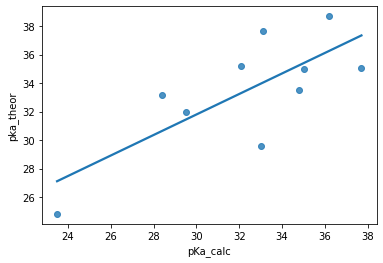

In [54]:
sns.regplot(data=df1_alpb_pka, x='pKa_calc', y='pka_theor', ci=None)
# plt.ylim(bottom=0)
# plt.xlim(left=0)
plt.show()

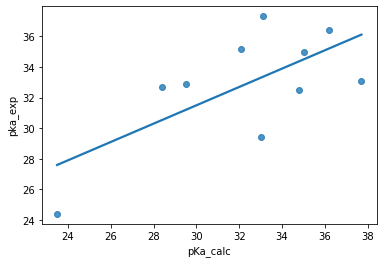

In [55]:
sns.regplot(data=df1_alpb_pka, x='pKa_calc', y='pka_exp', ci=None)
# plt.ylim(bottom=0)
# plt.xlim(left=0)
plt.show()

In [56]:
# Calculating prediction y values in sklearn
from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# model.fit(df1_alpb[['x']], df1_alpb['y'])
# y_2 = model.predict(df[['x']])
# df['y_predicted'] = y_2
# print(df.head())

model = LinearRegression()
m2 = model.fit(df1_alpb_pka[['pKa_calc']], df1_alpb_pka['pka_theor'])
y_2 = m2.predict(df1_alpb_pka[['pKa_calc']])
df1_alpb_pka['y_predicted_theor'] = y_2
print('pka_calc vs pka_theor')
print(f"score : {m2.score(df1_alpb_pka[['pKa_calc']], df1_alpb_pka['pka_theor'])}")
print(f"coef : {m2.coef_}")
print(f"intercept : {m2.intercept_}")

print('-'*40)
print('pka_calc vs pka_exp')
m3 = model.fit(df1_alpb_pka[['pKa_calc']], df1_alpb_pka['pka_exp'])
y_3 = m3.predict(df1_alpb_pka[['pKa_calc']])
print(f"score : {m3.score(df1_alpb_pka[['pKa_calc']], df1_alpb_pka['pka_exp'])}")
print(f"coef : {m3.coef_}")
print(f"intercept : {m3.intercept_}")
df1_alpb_pka['y_predicted_exp'] = y_3
print(df1_alpb_pka.head())

pka_calc vs pka_theor
score : 0.5711352323013186
coef : [0.72195587]
intercept : 10.139166839014553
----------------------------------------
pka_calc vs pka_exp
score : 0.4543452882259289
coef : [0.59910003]
intercept : 13.521096007169664
   pka_theor  pka_exp  pKa_calc  y_predicted_theor  y_predicted_exp
0       35.0     35.0      35.0          35.407622        34.489597
1       33.5     32.5      34.8          35.263231        34.369777
2       38.7     36.4      36.2          36.273969        35.208517
3       35.1     33.1      37.7          37.356903        36.107167
4       29.6     29.4      33.0          33.963710        33.291397


In [57]:
# Calculating the MSE with sklearn
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(df['y'], df['y_predicted'])
# rmse = mean_squared_error(df['y'], df['y_predicted'], squared=False)
# rmse = sqrt(mse)
# print(mse)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df1_alpb_pka['pka_theor'], df1_alpb_pka['y_predicted_theor'])
rmse = mean_squared_error(df1_alpb_pka['pka_theor'], df1_alpb_pka['y_predicted_theor'], squared=False)
# rmse = sqrt(mse)
print('pka_calc vs pka_theor')
print(f"mse: {mse}")
print(f"rmse: {rmse}")

pka_calc vs pka_theor
mse: 6.244957201321121
rmse: 2.4989912367435627


In [58]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df1_alpb_pka['pka_exp'], df1_alpb_pka['y_predicted_exp'])
rmse = mean_squared_error(df1_alpb_pka['pka_exp'], df1_alpb_pka['y_predicted_exp'], squared=False)
# rmse = sqrt(mse)
print('pka_calc vs pka_exp')
print(f"mse: {mse}")
print(f"rmse: {rmse}")

pka_calc vs pka_exp
mse: 6.877923076440989
rmse: 2.6225794699953306


In [ ]:
#spearman rank correlation
# my_r = x_simple.corr(method="spearman")

# def display_correlation(df):
#     r = df.corr(method="spearman")
#     plt.figure(figsize=(10,6))
#     heatmap = sns.heatmap(df.corr(), vmin=-1, 
#                       vmax=1, annot=True)
#     plt.title("Spearman Correlation")
#     return(r)